In [1]:
# sets the correct path, don't know how to toggle this once it is set
%cd ../
%pwd

/home/thomas/Development/resonator-hackathon/ssm/equinox


/home/thomas/Development/resonator-hackathon/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/thomas/Development/resonator-hackathon/ssm/equinox'

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import jax 
import jax.numpy as jnp
import equinox as eqx
import optax
from tqdm import tqdm
from typing import Callable
import wandb
import math
import numpy as np

from resonator_s5.classifier import Classifier
from functools import partial

import tonic
import tonic.transforms as transforms
from tonic import DiskCachedDataset


def downsample(x: np.ndarray) -> np.ndarray:
    """
    Input: (T, 700)
    Output: (T, 140)
    """
    x = x.reshape((-1, 14, 50))
    x = x.sum(axis=-1)
    return x


shd_sensor_size = (700, 1, 1)
bins = 250
pre_cache_transform = transforms.Compose([
    # tonic.transforms.ToFrame(
    #     sensor_size=(700, 1, 1), # ssc.sensor_size = (700, 1, 1) 
    #     time_window=1000,
    # ),
    # tonic.transforms.CropTime(max=100000),
    tonic.transforms.Downsample(sensor_size=shd_sensor_size, target_size=(140, 1)),
])
post_cache_train_transform = transforms.Compose([
    # tonic.transforms.UniformNoise(sensor_size=shd_sensor_size, n=1000),
    # tonic.transforms.SpatialJitter(
    #         sensor_size=shd_sensor_size, 
    #         var_x=1, 
    #         var_y=1, 
    #         clip_outliers=True
    #     ),
    tonic.transforms.TimeJitter(std=100, clip_negative=True),
    # tonic.transforms.DropEvent(p=0.33),
    tonic.transforms.ToFrame(
        sensor_size=(140, 1, 1), 
        n_time_bins=bins,
    ),
    torchvision.transforms.Lambda(lambda x: x[:, 0, :]),
    torchvision.transforms.Lambda(lambda x: (x > 0).astype(np.int32)),
])
post_cache_val_transform = transforms.Compose([
    # tonic.transforms.UniformNoise(sensor_size=shd_sensor_size, n=1000),
    # tonic.transforms.SpatialJitter(
    #         sensor_size=shd_sensor_size, 
    #         var_x=1, 
    #         var_y=1, 
    #         clip_outliers=True
    #     ),
    # tonic.transforms.TimeJitter(std=100, clip_negative=True),
    # tonic.transforms.DropEvent(p=0.33),
    tonic.transforms.ToFrame(
        sensor_size=(140, 1, 1), 
        n_time_bins=bins,
    ),
    torchvision.transforms.Lambda(lambda x: x[:, 0, :]),
    torchvision.transforms.Lambda(lambda x: (x > 0).astype(np.int32)),
])


train_dataset = tonic.datasets.SHD(save_to="../../data", train=True, transform=pre_cache_transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])
test_dataset = tonic.datasets.SHD(save_to="../../data", train=False, transform=pre_cache_transform)

train_dataset = DiskCachedDataset(train_dataset, cache_path="../../data/tonic/cache/shd/train", transform=post_cache_train_transform)
val_dataset = DiskCachedDataset(val_dataset, cache_path="../../data/tonic/cache/shd/val", transform=post_cache_val_transform)
test_dataset = DiskCachedDataset(test_dataset, cache_path="../../data/tonic/cache/shd/test", transform=post_cache_val_transform)


BATCH_SIZE = 32
NUM_CLASSES = 20
EPOCHS = 20

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/home/thomas/Development/resonator-hackathon/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
x, y = next(iter(train_dataloader))
x.shape

torch.Size([32, 250, 140])

In [4]:
rng_key = jax.random.PRNGKey(42)
rng_key, model_key = jax.random.split(rng_key, num=2)

model = Classifier(
    rng_key=model_key,
    input_dim=140,
    output_dim=NUM_CLASSES,
    num_neurons=[128],
    # num_neurons=[4],
    num_blocks=[16],
    # num_blocks=[1],
    dt_min=0.001,
    dt_max=0.1,
    activation="cartesian_spike",
    discretization="zoh",
    bidirectional=False,
    keep_imag=True,
    v_pos="before_spike",
    apply_skip=True,
    dropout=0.2,
    dense_dropout = False,
)
model

2024-06-16 23:18:55.483406: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Classifier(
  dense_layers=[
    RFDense(
      C=f32[128,140,2],
      keep_imag=True,
      norm=RadialNorm(
        norm=LayerNorm(
          shape=(128,),
          eps=1e-05,
          use_weight=True,
          use_bias=True,
          weight=f32[128],
          bias=f32[128]
        ),
        keep_imag=True
      )
    )
  ],
  neuron_layers=[
    RF(
      Lambda=f32[128,2],
      V=c64[128,128],
      log_step=f32[128,1],
      keep_imag=True,
      discretization='zoh',
      activation='cartesian_spike',
      bidirectional=False,
      step_rescale=1.0
    )
  ],
  drop=Dropout(p=0.2, inference=False),
  output_dense=RFDense(
    C=f32[20,128,2],
    keep_imag=False,
    norm=RadialNorm(
      norm=LayerNorm(
        shape=(20,),
        eps=1e-05,
        use_weight=True,
        use_bias=True,
        weight=f32[20],
        bias=f32[20]
      ),
      keep_imag=False
    )
  ),
  li=LI(tau=f32[20], dim=20),
  apply_skip=True,
  dense_dropout=False
)

In [5]:
model.neuron_layers[0].Lambda[...,1]

Array([-19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85741   ,
       -19.857405  ,  -5.3542137 ,  -1.9577932 ,  -0.427489  ,
         0.42748874,   1.9577956 ,   5.354209  ,  19.85

In [6]:
jnp.exp(model.forward(jnp.ones([4, 140]), rng_key=rng_key))

Array([0.02207322, 0.03181761, 0.01594134, 0.01285311, 0.01851891,
       0.03588828, 0.00778592, 0.04508015, 0.6173819 , 0.00984775,
       0.05325211, 0.03863542, 0.00599819, 0.00469681, 0.0166162 ,
       0.00471476, 0.00552831, 0.00344825, 0.0370319 , 0.01288987],      dtype=float32)

In [7]:
from resonator_s5.optax_helper import init_optimizer

decay_steps = EPOCHS * len(train_dataloader)
# if PERMUTE:
# standard_lr = 0.004
# ssm_lr = 0.001
# else:
standard_lr = 0.012
ssm_lr = 0.004

optim, opt_state = init_optimizer(model, standard_lr=standard_lr, ssm_lr=ssm_lr, weight_decay=0.0001, decay_steps=decay_steps)

In [8]:
opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']

Array(0.012, dtype=float32)

In [9]:
def loss_fn(model: Classifier, train_key, x: jax.Array, y: jax.Array):
    call = partial(model.forward, rng_key=train_key)
    batched_model = jax.vmap(call, in_axes=(0), out_axes=(0)) # add batch dim to x only
    logits = batched_model(x)
    loss = optax.softmax_cross_entropy(logits=logits, labels=y)
    loss = loss.mean()
    return loss, (logits)


# x , y = next(iter(test_dataloader))
# x = jnp.asarray(x.numpy())
# y = jnp.asarray(y.numpy())

# value, grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, rng_key, x, y)

# lrs = []
# for _ in tqdm(range(1080)):
#     updates, opt_state = optim.update(grads, opt_state, model)
#     lr = opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']
#     lrs.append(lr)

# model = eqx.apply_updates(model, updates)

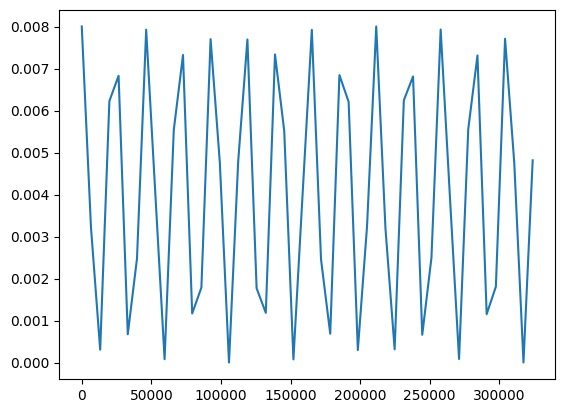

In [10]:
import matplotlib.pyplot as plt
x = jnp.linspace(0, 1080*300)
y = 0.008 * (1-1e-6)/2 * (1 + jnp.cos(jnp.pi * x/decay_steps)) + 1e-6
plt.plot(x, y)

In [11]:
opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']

Array(0.012, dtype=float32)

In [12]:
# @jax.jit
def cut_mix(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Performs cut mix augmentation: https://arxiv.org/pdf/1905.04899 but for a sequence.
    Code is deliberately in numpy and not jax.numpy cause it is simpler to work on mutable arrays.
    Input:
        x: (B, T, C)
        y: (B, 1)
    Output:
        x: (B, T, C)
        y: (B, 1)
    """
    B = x.shape[0]
    T = x.shape[1]

    lmbda = np.random.uniform(low=0, high=1)
    rand_index = np.random.permutation(np.arange(B))
    
    t1 = np.random.randint(low=0, high=T)
    t2 = int(T * (1-lmbda))
    
    t1_cut = np.clip((t1 - t2) // 2, a_min=0, a_max=T)
    t2_cut = np.clip((t1 + t2) // 2, a_min=0, a_max=T)

    lmbda = 1 - t2/T

    x[:, t1_cut:t2_cut, :] = x[rand_index, t1_cut:t2_cut, :]
    y = lmbda * y + (1-lmbda) * y[rand_index]
    return x, y

# @jax.jit
def one_hot(x: np.ndarray) -> np.ndarray:
    """
    Input: (B)
    Output: (B)
    """
    # x = x[:, 0]
    x = np.eye(NUM_CLASSES)[x]
    # x = x[:, None]
    return x 


def prep_data(x: torch.Tensor, y: torch.Tensor, training: bool) -> tuple[jax.Array, jax.Array]:
    x = x.numpy()
    y = y.numpy()
    y = one_hot(y)
    if training: 
        x, y = cut_mix(x, y)
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    return x, y

In [13]:
@eqx.filter_jit
def train_step(model: Classifier, train_key, opt_state, x: jax.Array, y: jax.Array):
    (loss_value, (logits)), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, train_key, x, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    metrics = {
        'loss': loss_value,
        'accuracy': jnp.mean(jnp.argmax(logits, axis=-1) == jnp.argmax(y, axis=-1)),
    }
    return model, opt_state, metrics


@eqx.filter_jit
def test_step(model: Classifier, rng_key, x, y):
    loss_value, (logits) = loss_fn(model, rng_key, x, y)
    metrics = {
        'loss': loss_value,
        # 'accuracy': jnp.mean(jnp.argmax(logits, -1) == y),
        'accuracy': jnp.mean(jnp.argmax(logits, axis=-1) == jnp.argmax(y, axis=-1)),
    }
    return metrics


@eqx.filter_jit
def get_average_spikes(model: Classifier, x: jax.Array, layer: int) -> tuple[jax.Array, jax.Array]:
    spikes_fn = partial(model.gen_spikes, layer=layer)
    spikes = jax.vmap(spikes_fn)(x)
    return (jnp.sum(spikes) / BATCH_SIZE).astype(jnp.int32), jnp.mean(spikes)



def train_epoch(model: Classifier, rng_key, opt_state, track_layer: int):
    train_metrics = {
        'loss': [],
        'accuracy': [],
    }
    val_metrics = {
        'loss': [],
        'accuracy': [],
        'num_spikes': [],
        'avg_spikes': [],
    }
    test_metrics = {
        'loss': [],
        'accuracy': [],
        'num_spikes': [],
        'avg_spikes': [],
    }
    print("training")
    for x, y in tqdm(train_dataloader):
        x, y = prep_data(x, y, training=True)
        rng_key, train_key = jax.random.split(rng_key, num=2)
        model, opt_state, metric = train_step(model, train_key, opt_state, x, y)
        train_metrics['loss'].append(metric['loss'])
        train_metrics['accuracy'].append(metric['accuracy'])

        # wandb.log({
        #      "loss": metric["loss"],
        #      "acc": metric["accuracy"],
        # })
    
    print("validating")
    inference_model = eqx.nn.inference_mode(model)
    for x, y in tqdm(val_dataloader): 
        x, y = prep_data(x, y, training=False)
        metric = test_step(inference_model, rng_key, x, y)
        val_metrics['loss'].append(metric['loss'])
        val_metrics['accuracy'].append(metric['accuracy'])

    num_spikes, avg_spikes = get_average_spikes(model, x, layer=track_layer)
    val_metrics['num_spikes'] = num_spikes
    val_metrics['avg_spikes'] = avg_spikes

    print("testing")
    for x, y in tqdm(test_dataloader): 
        x, y = prep_data(x, y, training=False)
        metric = test_step(inference_model, rng_key, x, y)
        test_metrics['loss'].append(metric['loss'])
        test_metrics['accuracy'].append(metric['accuracy'])
    
    num_spikes, avg_spikes = get_average_spikes(model, x, layer=track_layer)
    test_metrics['num_spikes'] = num_spikes
    test_metrics['avg_spikes'] = avg_spikes

    train_metrics['loss'] = jnp.array(train_metrics['loss']).mean()
    train_metrics['accuracy'] = jnp.array(train_metrics['accuracy']).mean()
    val_metrics['loss'] = jnp.array(val_metrics['loss']).mean()
    val_metrics['accuracy'] = jnp.array(val_metrics['accuracy']).mean()
    test_metrics['loss'] = jnp.array(test_metrics['loss']).mean()
    test_metrics['accuracy'] = jnp.array(test_metrics['accuracy']).mean()

    print(f"Train Loss: {train_metrics['loss']}")
    print(f"Train Acc: {train_metrics['accuracy']}")
    print(f"Val Loss: {val_metrics['loss']}")
    print(f"Val Acc: {val_metrics['accuracy']}")
    print(f"Test Loss: {test_metrics['loss']}")
    print(f"Test Acc: {test_metrics['accuracy']}\n")

    return model, opt_state, train_metrics, val_metrics, test_metrics

In [14]:
class BestAccTracker:
    def __init__(self) -> None:
        self.counter = 0
        self.best_acc = 0
    
    def update(self, x: jax.Array | float) -> None:
        if x > self.best_acc:
            self.best_acc = x
            self.reset_counter()
        else:
            self.counter += 1
    
    def reset_counter(self) -> None:
        self.counter = 0



some_nan = lambda x: np.sum(np.isnan(x)) > 0

In [15]:
from IPython.display import clear_output

wandb.init(project="S5_SHD")

rng_key = jax.random.PRNGKey(42)
tracker = BestAccTracker()
track_layer = 0
for epoch in range(EPOCHS):
    if (epoch % 5) == 0: 
        clear_output(wait=True)
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    model, opt_state, train_metrics, val_metrics, test_metrics = train_epoch(model, rng_key, opt_state, track_layer=track_layer)
    tracker.update(val_metrics["accuracy"])

    wandb.log({
        "Train Loss": train_metrics['loss'], 
        "Train Accuracy": train_metrics['accuracy'], 
        "Val Loss": val_metrics['loss'], 
        "Val Accuracy": val_metrics['accuracy'],
        "Test Loss": test_metrics['loss'], 
        "Test Accuracy": test_metrics['accuracy'],
        "Max Lambda real": -jnp.exp(model.neuron_layers[track_layer].Lambda[...,0].min()),
        "Min Lambda real": -jnp.exp(model.neuron_layers[track_layer].Lambda[...,0].max()),
        "Max Lambda imag": model.neuron_layers[track_layer].Lambda[...,1].max(),
        "Min Lambda imag": model.neuron_layers[track_layer].Lambda[...,1].min(),
        "Max C real": model.dense_layers[track_layer].C[...,0].max(),
        "Min C real": model.dense_layers[track_layer].C[...,0].min(),
        "Max C imag": model.dense_layers[track_layer].C[...,1].max(),
        "Min C imag": model.dense_layers[track_layer].C[...,1].min(),
        "Max Delta": jnp.exp(model.neuron_layers[track_layer].log_step.max()),
        "Min Delta": jnp.exp(model.neuron_layers[track_layer].log_step.min()),
        "Val Num Spikes": val_metrics['num_spikes'], 
        "Val Avg Spikes": val_metrics['avg_spikes'],
        "Test Num Spikes": test_metrics['num_spikes'], 
        "Test Avg Spikes": test_metrics['avg_spikes'],
        "Learning Rate Standard": opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate'],
        "Learning Rate SSM": opt_state.inner_states['ssm'].inner_state.hyperparams['learning_rate'],
        "Counter": tracker.counter,
        "Max Tau": jnp.exp(model.li.tau.max()),
        "Min Tau": jnp.exp(model.li.tau.min()),
        }
    )

    if tracker.counter >= 20:
        lr_standard = opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']
        lr_ssm = opt_state.inner_states['ssm'].inner_state.hyperparams['learning_rate']
        lr_standard = max(0.2 * lr_standard, 1e-6) 
        lr_ssm = max(0.2 * lr_ssm, 1e-6)
        opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate'] = lr_standard
        opt_state.inner_states['ssm'].inner_state.hyperparams['learning_rate'] = lr_ssm
        tracker.reset_counter()

    if some_nan(model.neuron_layers[track_layer].Lambda):
        print("Lambda nan")
        break
    if some_nan(model.dense_layers[track_layer].C):
        print("C nan")
        break
    if some_nan(model.neuron_layers[track_layer].log_step):
        print("Delta nan")
        break

wandb.finish()

Epoch: 16/20
training


100%|██████████| 230/230 [00:21<00:00, 10.89it/s]


validating


100%|██████████| 26/26 [00:02<00:00, 12.99it/s]


testing


100%|██████████| 71/71 [00:05<00:00, 12.70it/s]


Train Loss: 1.5268211364746094
Train Acc: 0.6741220355033875
Val Loss: 0.405047208070755
Val Acc: 0.934935986995697
Test Loss: 0.5043389797210693
Test Acc: 0.873826265335083

Epoch: 17/20
training


100%|██████████| 230/230 [00:21<00:00, 10.94it/s]


validating


100%|██████████| 26/26 [00:02<00:00, 12.47it/s]


testing


100%|██████████| 71/71 [00:05<00:00, 12.49it/s]


Train Loss: 1.5055928230285645
Train Acc: 0.6967390775680542
Val Loss: 0.36952415108680725
Val Acc: 0.9421474933624268
Test Loss: 0.45366528630256653
Test Acc: 0.9002347588539124

Epoch: 18/20
training


100%|██████████| 230/230 [00:20<00:00, 11.15it/s]


validating


100%|██████████| 26/26 [00:01<00:00, 13.22it/s]


testing


100%|██████████| 71/71 [00:05<00:00, 12.64it/s]


Train Loss: 1.4434901475906372
Train Acc: 0.7217391133308411
Val Loss: 0.36426717042922974
Val Acc: 0.9421474933624268
Test Loss: 0.4603614807128906
Test Acc: 0.8896713852882385

Epoch: 19/20
training


100%|██████████| 230/230 [00:20<00:00, 11.04it/s]


validating


100%|██████████| 26/26 [00:01<00:00, 13.11it/s]


testing


100%|██████████| 71/71 [00:05<00:00, 12.73it/s]


Train Loss: 1.5637776851654053
Train Acc: 0.6625731587409973
Val Loss: 0.3618309497833252
Val Acc: 0.9433494210243225
Test Loss: 0.45721161365509033
Test Acc: 0.89011150598526

Epoch: 20/20
training


100%|██████████| 230/230 [00:20<00:00, 11.05it/s]


validating


100%|██████████| 26/26 [00:02<00:00, 12.41it/s]


testing


100%|██████████| 71/71 [00:05<00:00, 12.83it/s]


Train Loss: 1.4875482320785522
Train Acc: 0.6962687969207764
Val Loss: 0.36116454005241394
Val Acc: 0.9445513486862183
Test Loss: 0.45818549394607544
Test Acc: 0.8918720483779907



Counter,▁▁▁▁▅▁▁▁▁▁▅█▁▁▅▁▁▅▁▁
Learning Rate SSM,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
Learning Rate Standard,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
Max C imag,▁▂▃▄▄▄▅▆▆▇▇▇▇███████
Max C real,▁▃▄▅▆▆▇▇▇▇▇▇████████
Max Delta,▁▁▂▃▄▄▅▆▆▇▇▇████████
Max Lambda imag,▁▃▃▄▆▆▆▇█▇▆▇▆▆▆▆▆▆▆▆
Max Lambda real,▁▄▅▆▆▇▇▇▇▇▇█████████
Max Tau,▄██▆▃▂▂▄▁▂▃▃▃▄▄▄▄▅▅▅
Min C imag,█▆▅▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁
Min C real,█▇▆▅▄▄▃▄▃▃▂▂▂▂▁▁▁▁▁▁


In [16]:
opt_state.inner_states['standard'].inner_state#.hyperparams['learning_rate']

InjectStatefulHyperparamsState(count=Array(4600, dtype=int32), hyperparams={'b1': Array(0.9, dtype=float32), 'b2': Array(0.999, dtype=float32), 'eps': Array(1.e-08, dtype=float32), 'eps_root': Array(0., dtype=float32), 'learning_rate': Array(1.343051e-08, dtype=float32), 'weight_decay': Array(1.e-04, dtype=float32)}, hyperparams_states={'learning_rate': WrappedScheduleState(count=Array(4600, dtype=int32))}, inner_state=(ScaleByAdamState(count=Array(4600, dtype=int32), mu=Classifier(
  dense_layers=[
    RFDense(
      C=f32[128,140,2],
      keep_imag=None,
      norm=RadialNorm(
        norm=LayerNorm(
          shape=(128,),
          eps=1e-05,
          use_weight=True,
          use_bias=True,
          weight=f32[128],
          bias=f32[128]
        ),
        keep_imag=None
      )
    )
  ],
  neuron_layers=[
    RF(
      Lambda=MaskedNode(),
      V=c64[128,128],
      log_step=MaskedNode(),
      keep_imag=None,
      discretization=None,
      activation=None,
      bidire

In [17]:
wandb.finish()

In [18]:
model.dense_layers[0].C

Array([[[ 1.6945453 , -0.09105453],
        [ 0.9472304 , -0.7211818 ],
        [ 0.60550076,  0.20982085],
        ...,
        [-0.14313047, -0.5309315 ],
        [-0.96435076, -1.2079037 ],
        [-0.48484454, -0.8738583 ]],

       [[ 0.15371886,  0.47946122],
        [-0.226671  ,  0.29307988],
        [-0.01795749,  0.6776771 ],
        ...,
        [-0.44939607,  0.04389553],
        [-0.22446273, -0.55251193],
        [ 0.19170943, -0.59145325]],

       [[ 0.01760202, -0.6743335 ],
        [ 0.14417213, -0.33295318],
        [-0.557708  ,  0.32900468],
        ...,
        [ 0.6475489 ,  0.74674433],
        [ 0.7771657 ,  0.21456248],
        [ 0.97595125, -0.37696716]],

       ...,

       [[ 0.44710022, -1.4274929 ],
        [-0.03711724, -0.12770925],
        [-0.22633979, -0.12638308],
        ...,
        [ 0.6466803 ,  0.1394302 ],
        [ 0.76558745,  0.08087797],
        [ 0.65164644,  0.38011366]],

       [[-0.54201615,  0.6657986 ],
        [-0.2630955 ,  0.55

In [19]:
model.neuron_layers[0].log_step

Array([[-3.0628486],
       [-4.94615  ],
       [-6.3977046],
       [-4.408176 ],
       [-1.3264714],
       [-2.689687 ],
       [-4.6144447],
       [-5.351161 ],
       [-4.0214357],
       [-3.8148272],
       [-3.6163616],
       [-6.355222 ],
       [-6.688379 ],
       [-2.2003102],
       [-4.943305 ],
       [-5.910438 ],
       [-4.7858396],
       [-3.6547344],
       [-2.3981118],
       [-6.782806 ],
       [-5.4899073],
       [-1.6012477],
       [-6.164247 ],
       [-6.507986 ],
       [-3.7550929],
       [-5.0030875],
       [-5.787726 ],
       [-5.6876864],
       [-5.1835117],
       [-3.569763 ],
       [-4.4375043],
       [-5.1648498],
       [-4.6933746],
       [-6.397506 ],
       [-3.237535 ],
       [-1.6212237],
       [-5.867413 ],
       [-2.097501 ],
       [-3.9255226],
       [-3.8473647],
       [-6.854124 ],
       [-2.8672235],
       [-4.8099895],
       [-6.1673417],
       [-1.9558371],
       [-2.0972188],
       [-6.0526094],
       [-3.57

In [20]:
model.neuron_layers[0].Lambda

Array([[ -0.47959086, -20.158566  ],
       [ -0.5775701 ,  -5.1191583 ],
       [ -0.59938186,  -1.7237703 ],
       [ -0.29595813,  -0.39190152],
       [ -0.7254591 ,   0.575239  ],
       [ -0.4579649 ,   1.9516871 ],
       [ -0.3966342 ,   5.216302  ],
       [ -0.763338  ,  19.759146  ],
       [ -0.4422997 , -19.753523  ],
       [ -0.3113312 ,  -5.107909  ],
       [ -1.0330007 ,  -1.8259252 ],
       [ -1.1595767 ,  -0.56729466],
       [ -0.8670107 ,  -0.03221381],
       [ -0.73065406,   1.8678153 ],
       [ -0.89001   ,   5.194512  ],
       [ -1.4404446 ,  19.668474  ],
       [ -0.4098064 , -19.71231   ],
       [ -0.9560309 ,  -5.2777996 ],
       [ -0.9593077 ,  -1.9572742 ],
       [ -0.6929958 ,  -0.4050193 ],
       [ -0.6038202 ,   0.38131467],
       [ -0.8944244 ,   2.2850547 ],
       [ -0.6255032 ,   5.461524  ],
       [ -1.2075918 ,  19.792465  ],
       [ -0.72447664, -19.490925  ],
       [ -1.6031607 ,  -5.3483377 ],
       [ -0.92393064,  -2.1150787 ],
 

In [21]:
raise Exception()

Exception: 

# Plots for Surrogat Gradients

In [ ]:
import matplotlib.pyplot as plt

x = jnp.linspace(-3, 3, 100)
h = 0.15
s = 6
sigma = 0.5
theta = 0
gaussian1 = lambda x, mu, std: jnp.exp(-0.5*((x-mu)/std)**2)

df1 = (1+h)*gaussian1(x, theta, sigma) - 2*h*gaussian1(x, theta, s*sigma)

plt.plot(x, df1)

In [ ]:
import matplotlib.pyplot as plt

x = jnp.linspace(-3, 3, 100)
h = 0.15
s = 6
sigma = 0.5
theta = 0
gaussian2 = lambda x, mu, std: 1/((2*jnp.pi)**(0.5) * std) * jnp.exp(-0.5*((x-mu)/std)**2)

df2 = (1+h)*gaussian2(x, theta, sigma) - h*gaussian2(x, sigma, s*sigma) - h*gaussian2(x, -sigma, s*sigma)

plt.plot(x, df2)

In [ ]:
import matplotlib.pyplot as plt

x = jnp.linspace(-3, 3, 100)
h = 0.15
s = 6
sigma = 0.5
theta = 0
gaussian2 = lambda x, mu, std: 1/((2*jnp.pi)**(0.5) * std) * jnp.exp(-0.5*((x-mu)/std)**2)

df3 = (4 / (jnp.exp(-x) + jnp.exp(x))**2).astype(jnp.float32)

plt.plot(x, df3)

In [ ]:
df1

In [ ]:
df2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

P0 = lambda x: np.ones_like(x)
P1 = lambda x: x
P2 = lambda x: (1/2) * (3 * x**2 - 1)
P3 = lambda x: (1/2) * (5 * x**3 - 3*x)
P4 = lambda x: (1/8) * (35 * x**4 - 30*x**2 + 3)
P5 = lambda x: (1/8) * (63 * x**5 - 70*x**3 + 15*x)
P6 = lambda x: (1/16) * (231 * x**6 - 315*x**4 + 105*x**2-5)

factor = lambda n: (2*n+1) / 2

x = np.linspace(-6, 6, 100)
x0 = 0.5
y = factor(0)*P0(x0)*P0(x) * factor(1)*P1(x0)*P1(x) * factor(2)*P2(x0)*P2(x) * factor(3)*P3(x0)*P3(x) * factor(4)*P4(x0)*P4(x) * factor(5)*P5(x0)*P5(x) * factor(6)*P6(x0)*P6(x)

In [ ]:
plt.plot(x, y)

In [ ]:
plt.plot(x, P6(x))

In [ ]:
def sin(m, x):
    # return 2**(0.5) * np.sin(2*np.pi * m * x)
    return np.sin(2*np.pi * m * x)

def cos(m, x):
    # return 2**(0.5) * np.cos(2*np.pi * m * x)
    return np.cos(2*np.pi * m * x)

def basis(n, x):
    if np.abs(n) % 2 == 0:
        return sin(n/2, x)
    else:
        return cos(int(n/2), x)


x = np.linspace(-5, 5, 100)
x0 = 2.1
y = np.sum(np.array([basis(n, x0) * basis(n, x) for n in range(-64, 64, 1)]), axis=0)

In [ ]:
plt.plot(x, y)

In [ ]:
y = [0, 0, 1, 0, 0]
np.fft.fft(y*2)